# Importar librería 

In [22]:
import re
import os
import glob
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
tf.debugging.set_log_device_placement(True)


# Extract data

In [2]:
def extract_data_from_xml(xml_file):
    with open(xml_file, "r") as f:
        content = f.read()
        soup = BeautifulSoup(content, "lxml-xml")
    
    subject_id = soup.find('ID').string
    writings = []
    for writing in soup.find_all('WRITING'):
        writing_data = {}
        writing_data['ID'] = subject_id
        writing_data['TITLE'] = writing.find('TITLE').text
        writing_data['DATE'] = writing.find('DATE').text
        writing_data['TEXT'] = writing.find('TEXT').text
        info_tag = writing.find('INFO')
        writing_data['INFO'] = info_tag.string if info_tag else None
        writings.append(writing_data)
    return writings

def xml_csv(path, path_risk):
    xml_list = []
    files = glob.glob(os.path.join(path, '*.xml'))
    
    for xml_file in files:
        writings = extract_data_from_xml(xml_file)
        xml_list.extend(writings)
    
    column_name = ['ID', 'DATE', 'TITLE', 'TEXT', 'INFO']
    xml_df = pd.DataFrame(xml_list, columns=column_name).set_index(['ID', 'DATE']).sort_index()
    
    with open(path_risk) as gt:
        xml_df["LABEL"] = np.nan
        for line in gt:
            if line == '\n':
                break
            rec_id, value = line.split(' ', 1)
            if rec_id in xml_df.index:
                xml_df.loc[rec_id, 'LABEL'] = int(value)
    
    xml_df['LABEL'] = xml_df['LABEL'].astype('int')
    
    train_data, test_data = train_test_split(xml_df, test_size=0.2, stratify=xml_df['LABEL'], random_state=42)
    
    train_data.to_csv(path_train_csv)
    test_data.to_csv(path_test_csv)

    return train_data, test_data


In [3]:
SST_HOME='/data/hshan/eRisk/'
path_train_csv=SST_HOME+'dataset/t2_training_data/train21_22.csv'
path_test_csv=SST_HOME+'dataset/t2_test_data/test21_22.csv'
path = '/data/hshan/eRisk/dataset/eRisk202_T2_original/eRisk2021_T1/data'
path_risk = '/data/hshan/eRisk/dataset/eRisk202_T2_original/eRisk2021_T1/risk_golden_truth.txt'
train_df, test_df = xml_csv(path, path_risk)


train_texts = train_df['TITLE'].astype(str) + " " + train_df['TEXT'].astype(str)
test_texts = test_df['TITLE'].astype(str) + " " + test_df['TEXT'].astype(str)
train_labels = train_df['LABEL'].values
test_labels = test_df['LABEL'].values

combined_texts = train_df['TITLE'] + " " + train_df['TEXT']

# Limpiezas de datos

In [4]:
def replace_unicode(match):
    """Replace unicode code value with symbol."""
    unicode_value = int(match.group('unicode'))
    return chr(unicode_value)
def replace_html_characters(match):
    """Replace HTML code value with symbol."""
    html_character = match.group('html')
    if html_character == 'amp':
        return '&'
    elif html_character == 'lt':
        return '<'
    elif html_character == 'gt':
        return '>'
def get_cleaned_post(post):
    """Clean post."""
    # Transform post to lowercase.
    clean_post = post.lower()
    # Replace unicode values with their symbol.
    clean_post = UNICODE_REGEX.sub(repl=replace_unicode, string=clean_post)
    # Replace the HTML codes with their symbol.
    clean_post = HTML_REGEX.sub(repl=replace_html_characters, string=clean_post)
    # Replace links to pages in reddit format with the token `weblink`.
    clean_post = URL_FORMAT_PATTERN.sub(repl='weblink', string=clean_post)
    # Replace direct links to pages with the token `weblink`.
    clean_post = WEB_URL_REGEX.sub(repl='weblink', string=clean_post)
    # Replace link to subreddit with the subreddit name.
    clean_post = SUB_REDDIT_REGEX.sub(repl=r'\g<subreddit>', string=clean_post)
    # Remove all characters except for letters, numbers and white spaces.
    clean_post = NOT_WORD_REGEX.sub(repl='', string=clean_post)
    # Replace sequence of numbers with the token `number`. This doesn't hold if
    # the sequence is not composed of numbers only.
    clean_post = NUMBER_REGEX.sub(repl='number', string=clean_post)
    # Remove repeated white spaces, new lines and tabs.
    clean_post = " ".join(clean_post.split())
    # If the document ends up empty, add the word "empty" to represent it.
    clean_post = clean_post + 'empty' if clean_post == '' else clean_post
    return clean_post


# Tokenizacion Versión 1

In [6]:

def load_glove_embeddings(path):
    embeddings_index = dict() 
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def preprocess_with_spacy_optimized(df, embeddings_index, tokenizer=None, max_length=512, max_words=10000):
    df['TEXT'] = df['TEXT'].apply(get_cleaned_post)
    df['TITLE'] = df['TITLE'].apply(get_cleaned_post)
    texts = df['TITLE'] + " " + df['TEXT']
    nlp = spacy.load("en_core_web_md") #descargar el modelo spacy
    #expresion regular para eliminar url y menciones   
    processed_texts = []
    for text in texts:

        # Use spaCy for lemmatization and removing stopwords
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        
        processed_texts.append(' '.join(tokens))
    oov_token = "<OOV>"
    if tokenizer is None:
        tokenizer = Tokenizer(num_words = max_words, oov_token=oov_token)
        tokenizer.fit_on_texts(processed_texts)
        
    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(processed_texts)
    
    if max_length is None:
        max_length = max(len(sequence) for sequence in sequences)
    
    padding_type='post'
    truncation_type='post'
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
    
    
    # Create embedding matrix
    embedding_dim = len(next(iter(embeddings_index.values())))  # dimension of embeddings
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return padded_sequences,  df['LABEL'].values,tokenizer, max_length, embedding_matrix,word_index,processed_texts

In [7]:
xml_directory = '/data/hshan/eRisk/dataset/eRisk202_T2_original/eRisk2021_T1/data'#path donde guarda los ficheros xml 
risk_file_path = "/data/hshan/eRisk/dataset/eRisk202_T2_original/eRisk2021_T1/risk_golden_truth.txt"
UNICODE_REGEX = re.compile(r' #(?P<unicode>\d+);')
HTML_REGEX = re.compile(r'[ &](?P<html>amp|lt|gt);')
URL_FORMAT_PATTERN = re.compile(r'\[[^]]+?\]\(.+?\)')
WEB_URL_REGEX = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
SUB_REDDIT_REGEX = re.compile(r'/r/(?P<subreddit>[a-z0-9_]+?\b)')
NUMBER_REGEX = re.compile(r'\b[0-9]+?\b')
NOT_WORD_REGEX = re.compile(r"[^a-z0-9 ']")
# Load GloVe word embeddings
glove_path = '/tmp/glove/glove.twitter.27B.100d.txt'  # Adjust this to your actual GloVe file path
embeddings_index = load_glove_embeddings(glove_path)
# Preprocess the training data
train_x_processed, train_y, tokenizer, max_length, embedding_matrix,word_index,processed_texts = preprocess_with_spacy_optimized(train_df,embeddings_index)

# Preprocess the testing data using the same tokenizer and max_length
test_x_processed,test_y,_, _, _,_,_= preprocess_with_spacy_optimized(test_df, embeddings_index, tokenizer, max_length)


In [9]:
train_x_clean

['empty jesus fuck man   made my   take number hours instead of number',
 'looking for housing in  hi everyone  searching for housing in  but  am not sure which websites  should be looking on as it might not be reliable does anyone have advice reliable websites number months  number ',
 'is there  future for me  just keep getting convinced that all  doing is for nothing  keep getting high  and have promising  in multiple  but  always keep getting  that  may not have  future ahead of me why should  even begin to plan what to do after college if   convince myself that  have  future ahead despite all that  have  am so sick and tired of everyone else being unable to take their own problems seriously my mother is   and  and keeps making every problem blow out of  and just  everyone else to forget every huge problem that she started  worse is that she is  to my facebook profile so    about it there and get the attention  needed she never  or  and every time  talk to her about my problems is 

# SMOTE Version

Epoch 1/10
48325/48325 [==============================] - 6156s 127ms/step - loss: 0.3617 - accuracy: 0.8314 - auc: 0.9109 - val_loss: 0.3226 - val_accuracy: 0.8808 - val_auc: 0.7092
Epoch 2/10
48325/48325 [==============================] - 6143s 127ms/step - loss: 0.3140 - accuracy: 0.8578 - auc: 0.9329 - val_loss: 0.2957 - val_accuracy: 0.8968 - val_auc: 0.7258
Epoch 3/10
48325/48325 [==============================] - 6151s 127ms/step - loss: 0.2955 - accuracy: 0.8676 - auc: 0.9408 - val_loss: 0.3193 - val_accuracy: 0.8771 - val_auc: 0.7431
Epoch 4/10
48325/48325 [==============================] - 6148s 127ms/step - loss: 0.2818 - accuracy: 0.8741 - auc: 0.9462 - val_loss: 0.2827 - val_accuracy: 0.8991 - val_auc: 0.7220
Epoch 5/10
48325/48325 [==============================] - 6151s 127ms/step - loss: 0.2730 - accuracy: 0.8784 - auc: 0.9494 - val_loss: 0.3141 - val_accuracy: 0.8834 - val_auc: 0.7423
Epoch 6/10
48325/48325 [==============================] - 6135s 127ms/step - loss: 0.

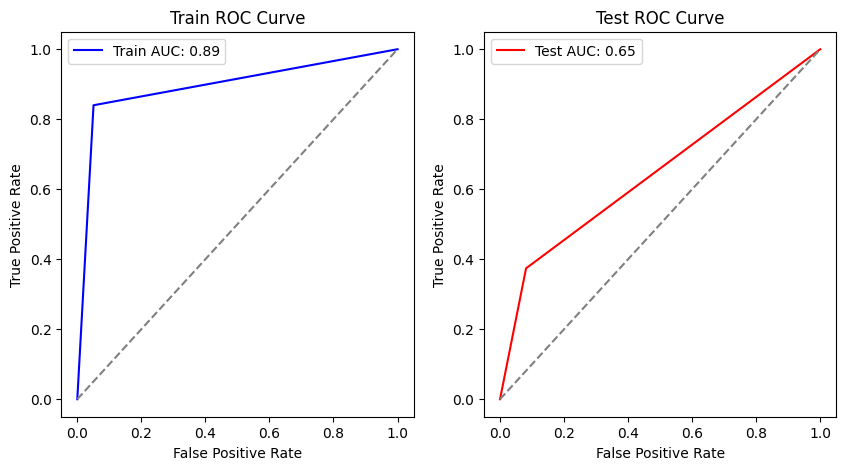

Train Accuracy: 0.9006931632338305, Precision: 0.9298366559982733, Recall: 0.8399395300923636, F1 Score: 0.8826048966418243, Loss: 3.5793812035694477
Test Accuracy: 0.8912628227803325, Precision: 0.1959674078165999, Recall: 0.3739787402266538, F1 Score: 0.25717392617652385, Loss: 3.919285126216701


In [27]:
# Define SMOTE strategy
over = SMOTE(sampling_strategy=0.8)

# Define under sampling strategy
under = RandomUnderSampler(sampling_strategy=0.8, random_state=9)

# Define pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset using SMOTE and RandomUnderSampler
train_x_resampled, train_y_resampled = pipeline.fit_resample(train_x_processed, train_y)
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(150, return_sequences=True)), 
    Dropout(0.3),
    Bidirectional(LSTM(150)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'AUC'])

# Now you can train your model with the resampled dataset
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Assuming you have already defined your model and compiled it
history = model.fit(train_x_resampled, train_y_resampled, epochs=10, batch_size=32, validation_data=(test_x_processed, test_y), callbacks=[early_stopping])

# Predicting on test data
y_pred_train = model.predict(train_x_resampled)
y_pred_test = model.predict(test_x_processed)

# Converting probabilities to class labels
y_pred_train = [1 if p > 0.5 else 0 for p in y_pred_train]
y_pred_test = [1 if p > 0.5 else 0 for p in y_pred_test]

#calculation auc score on training and test data
train_auc = roc_auc_score(train_y_resampled, y_pred_train)
test_auc = roc_auc_score(test_y, y_pred_test)

print('Train AUC-ROC: {}'.format(train_auc))
print('Test AUC-ROC: {}'.format(test_auc))

# calculation ROC curve
fpr_train, tpr_train, _ = roc_curve(train_y_resampled, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(test_y, y_pred_test)

# plotting ROC curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='blue', label='Train AUC: {:.2f}'.format(train_auc))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='red', label='Test AUC: {:.2f}'.format(test_auc))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend()

plt.show()
# Calculating metrics on training data
train_accuracy = accuracy_score(train_y_resampled, y_pred_train)
train_precision = precision_score(train_y_resampled, y_pred_train)
train_recall = recall_score(train_y_resampled, y_pred_train)
train_f1 = f1_score(train_y_resampled, y_pred_train)
train_loss = log_loss(train_y_resampled, y_pred_train)

# Calculating metrics on testing data
test_accuracy = accuracy_score(test_y, y_pred_test)
test_precision = precision_score(test_y, y_pred_test)
test_recall = recall_score(test_y, y_pred_test)
test_f1 = f1_score(test_y, y_pred_test)
test_loss = log_loss(test_y, y_pred_test)

print('Train Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}, Loss: {}'.format(train_accuracy, train_precision, train_recall, train_f1, train_loss))
print('Test Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}, Loss: {}'.format(test_accuracy, test_precision, test_recall, test_f1, test_loss))


In [26]:
model.save('my_model_unsl_gpu_smote_undersampling_v2.h5')

/data/hshan/eriskvenv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
len(train_x_resampled)

257730

In [22]:
len(train_x_processed)

904639